In [1]:
!pip install wfdb --quiet
!pip install keras-tuner --quiet
!pip install resnet1d --quiet
!pip install tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement resnet1d (from versions: none)
ERROR: No matching distribution found for resnet1d


In [2]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [3]:
def bandpass_filter(signal, fs=250, lowcut=0.5,  highcut=15.0,  order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
def smooth_signal(data, window_size=5):
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)

In [4]:

from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)



In [5]:


def extract_wave_regions(samples, symbols, fs, extra_ms={'p':0,'N':20,'t':0}):
    wave_regions = {'p': [], 'N': [], 't': []}
    start = None
    qrs_symbols = ['N', 'L', 'R', 'V', 'A','/']
    current_symbol = None
    a = fs/ 1000
    for i in range(len(symbols)):

        if symbols[i] == '(':
            start = samples[i]
            current_symbol = None
        elif symbols[i] in wave_regions:

            current_symbol = symbols[i]
        elif symbols[i] in qrs_symbols:
            current_symbol = 'N'
        elif symbols[i] == ')' and current_symbol:
            end = samples[i]
            if start and end and current_symbol:
              #print(extra_ms['p'])
              wave_regions[current_symbol].append((int(start-extra_ms[current_symbol]*a), int(end+extra_ms[current_symbol]*a)))

            start = None
            current_symbol = None
    return wave_regions


In [6]:
def create_multi_class_mask(length, wave_regions):

    mask = np.zeros((length, 4))  # [BG, P, QRS, T]
    label_map = {'p': 1, 'N': 2, 't': 3}
    for label, regions in wave_regions.items():
        for start, end in regions:
            start = max(0, start)
            end = min(length, end)
            mask[start:end, label_map[label]] = 1

    mask[:, 0] = (mask[:, 1:] == 0).all(axis=1).astype(float)
    return mask

In [7]:
def segment_signal_and_mask(signal, mask, window_size, stride):
    segments, masks = [], []
    for i in range(0, len(signal) - window_size + 1, stride):
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        if len(segment) == window_size and len(mask_segment) == window_size:
            segments.append(segment)
            masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def display_ecg_with_masks(signal, mask, fs=250):
    
    time = np.arange(len(signal)) / fs 
    if mask.ndim == 1:
        num_classes = 4  
        mask = np.eye(num_classes)[mask]  

    plt.figure(figsize=(15, 6))
    plt.plot(time, signal, color='black', label='ECG Signal')

    plt.fill_between(time, -1, 1, where=mask[:, 0] > 0.5, color='gray', alpha=0.3, label='background')
    plt.fill_between(time, -1, 1, where=mask[:, 1] > 0.5, color='blue', alpha=0.3, label='P wave')
    plt.fill_between(time, -1, 1, where=mask[:, 2] > 0.5, color='red', alpha=0.3, label='QRS Complex')
    plt.fill_between(time, -1, 1, where=mask[:, 3] > 0.5, color='green', alpha=0.3, label='T wave')

    plt.title("ECG Signal with Annotated Wave Regions")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [9]:
import numpy as np
import wfdb

def process_record(record_path, Type='LUDB', extra_ms={'p':0,'N':20,'t':0}, target_fs=250, window_sec=1.0):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # lead I
    fs = record.fs

    annotations = wfdb.rdann(record_path, 'pu0' if Type == 'QTDB' else 'i')
    samples = annotations.sample
    symbols = annotations.symbol

    window_size = 240
    stride = window_size // 4  
    
    remainder = (len(signal) - window_size) % stride
    padding = (stride - remainder) if remainder != 0 else 0
    if padding > 0:
        signal = np.pad(signal, (0, padding), mode='constant', constant_values=signal[-1])

    
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
        samples = adjust_annotations(samples, original_fs=fs, target_fs=target_fs)
        fs = target_fs

    wave_regions = extract_wave_regions(samples, symbols, fs, extra_ms=extra_ms)
    mask = create_multi_class_mask(len(signal), wave_regions)

    indices = np.where(mask[:, 0] != 1)[0] 
    first_non_zero_row = indices[0] if len(indices) > 0 else None
    last_non_zero_row = indices[-1] if len(indices) > 0 else None
    

    padding = 5
    first_non_zero_row-=padding
    if (first_non_zero_row<0):first_non_zero_row=0
    last_non_zero_row+=padding
    if (last_non_zero_row>len(signal)-1):last_non_zero_row=len(signal)-1
    mask=mask[first_non_zero_row:last_non_zero_row]
    signal=signal[first_non_zero_row:last_non_zero_row]
    
    segments, masks = segment_signal_and_mask(signal, mask, window_size, stride)


    if len(segments) * stride + window_size - stride < len(signal):
        pad_needed = len(signal) - (len(segments) * stride + window_size - stride)
        signal = np.pad(signal, (0, pad_needed), mode='constant', constant_values=signal[-1])
        mask = np.pad(mask, (0, pad_needed), mode='constant', constant_values=0)  


    segments = np.expand_dims(segments, axis=1) 


    masks = np.argmax(masks, axis=-1)            

    return segments, masks


In [10]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  
path='/kaggle/input/qtdb-ludb/'
qtdb_path = path + "physionet.org/files/qtdb/1.0.0/"
ludb_path = path + "physionet.org/files/ludb/1.0.1/data/"


qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


Processing QTDB Records: 100%|██████████| 105/105 [00:17<00:00,  5.92it/s]


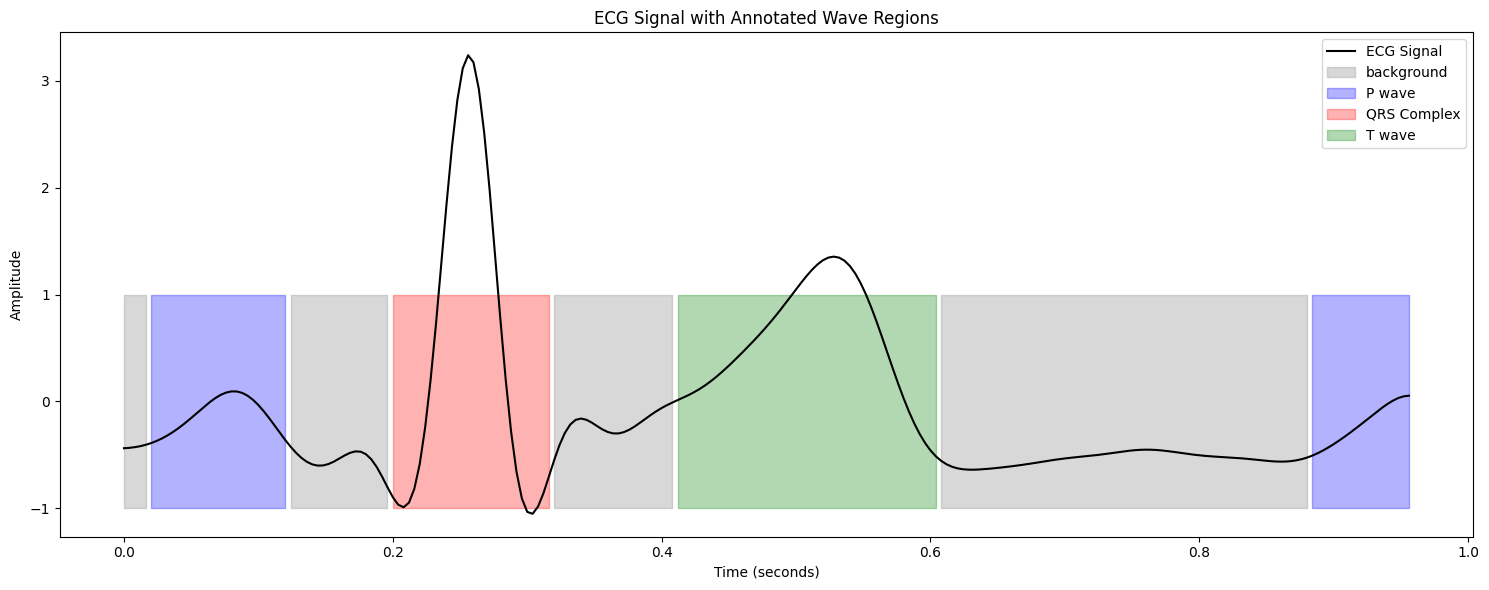

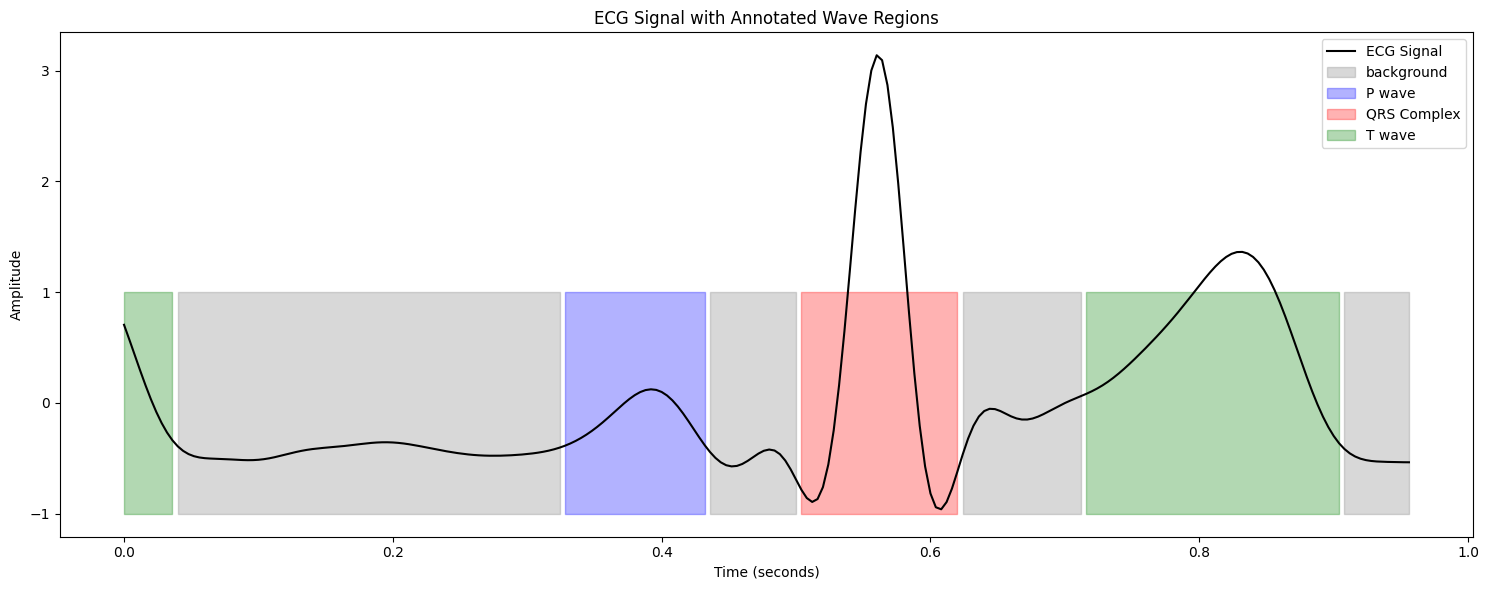

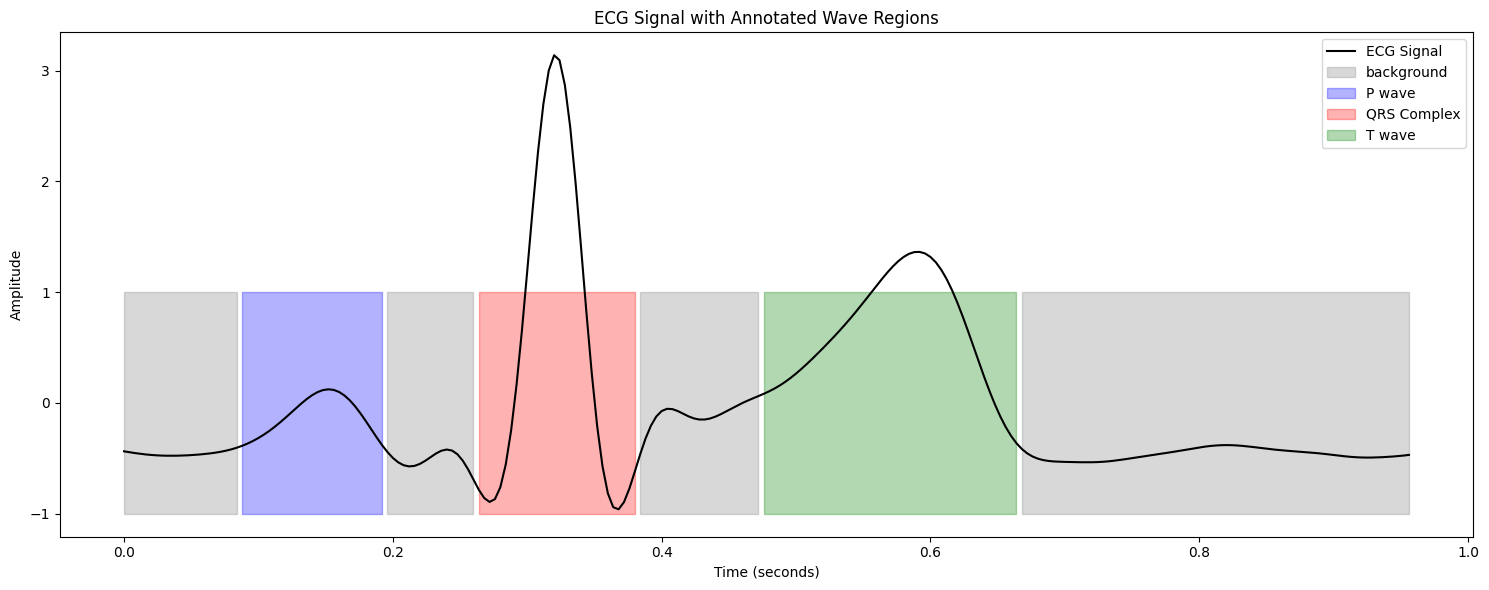

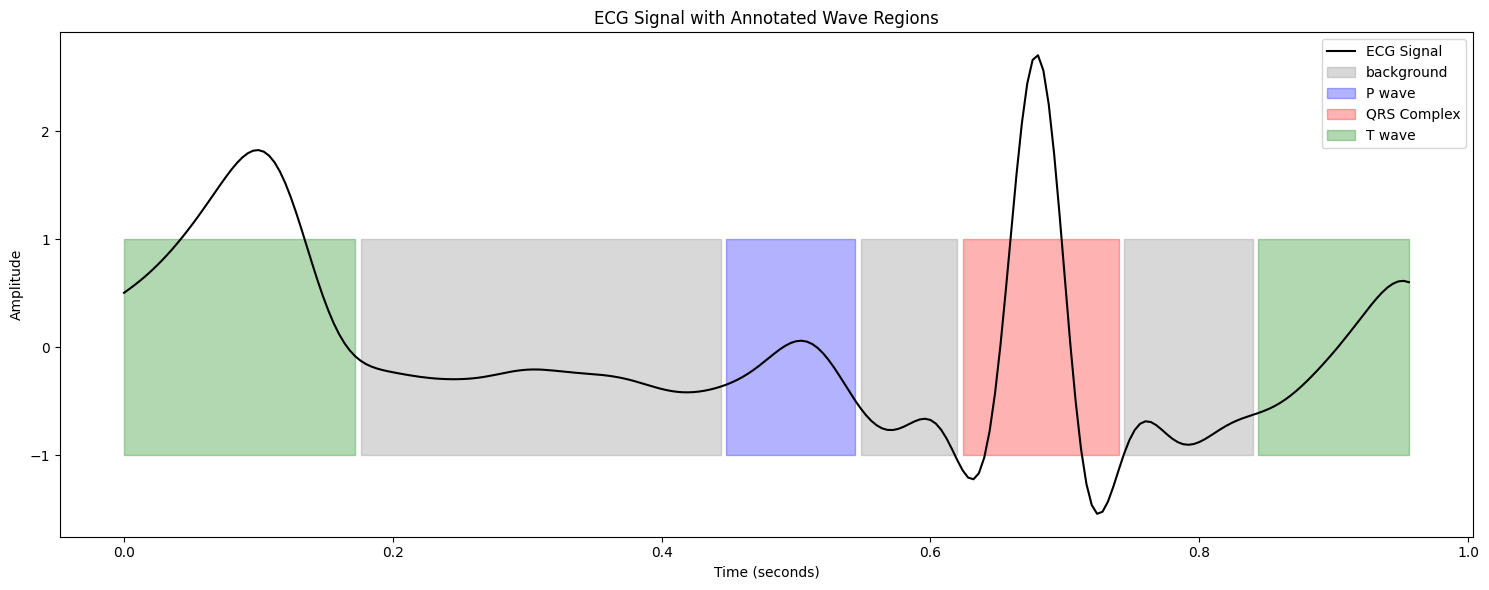

In [11]:
from tqdm import tqdm
qt_segments_list, qt_masks_list = [], []

for record_path in tqdm(qt_records, desc="Processing QTDB Records"):
#if(True):
#    record_path = "sel232"
    try:

        #print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms={'p':0,'N':20,'t':0},target_fs=250)  
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)

    except:
        print(f"Skipping {record_path} due to error.")

display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])



Processing LUDB Records: 100%|██████████| 200/200 [00:06<00:00, 31.07it/s]


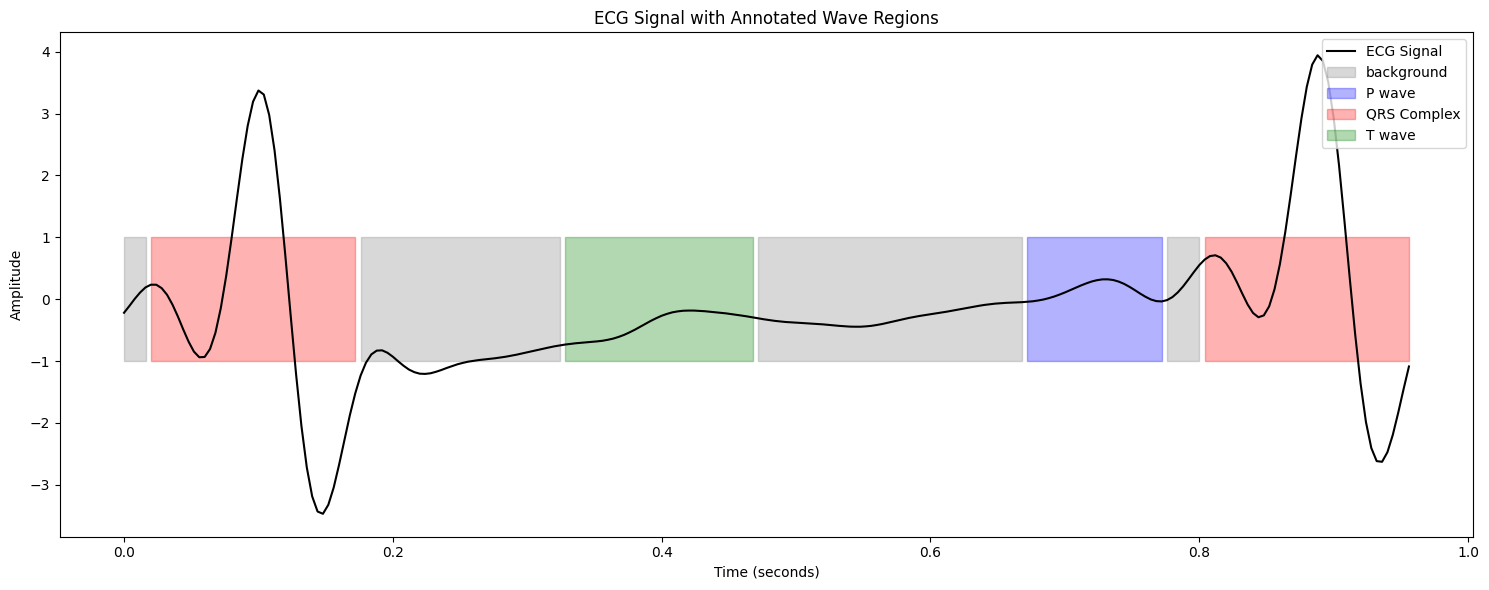

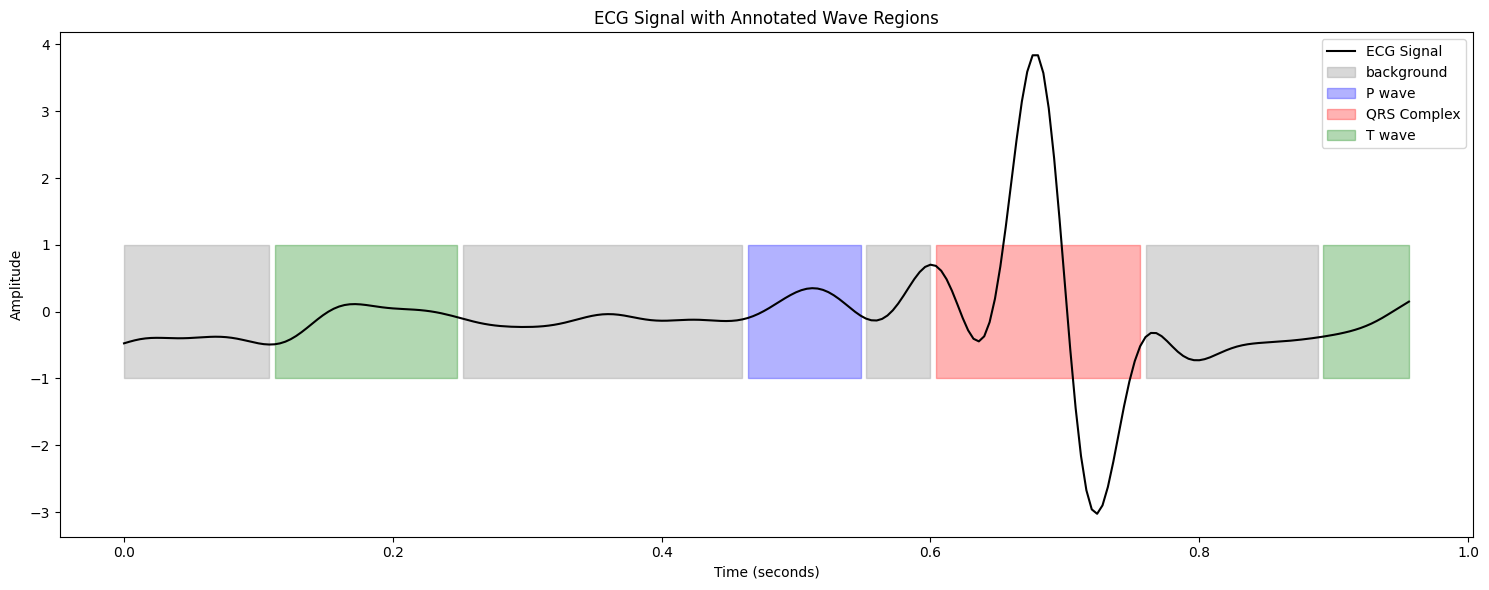

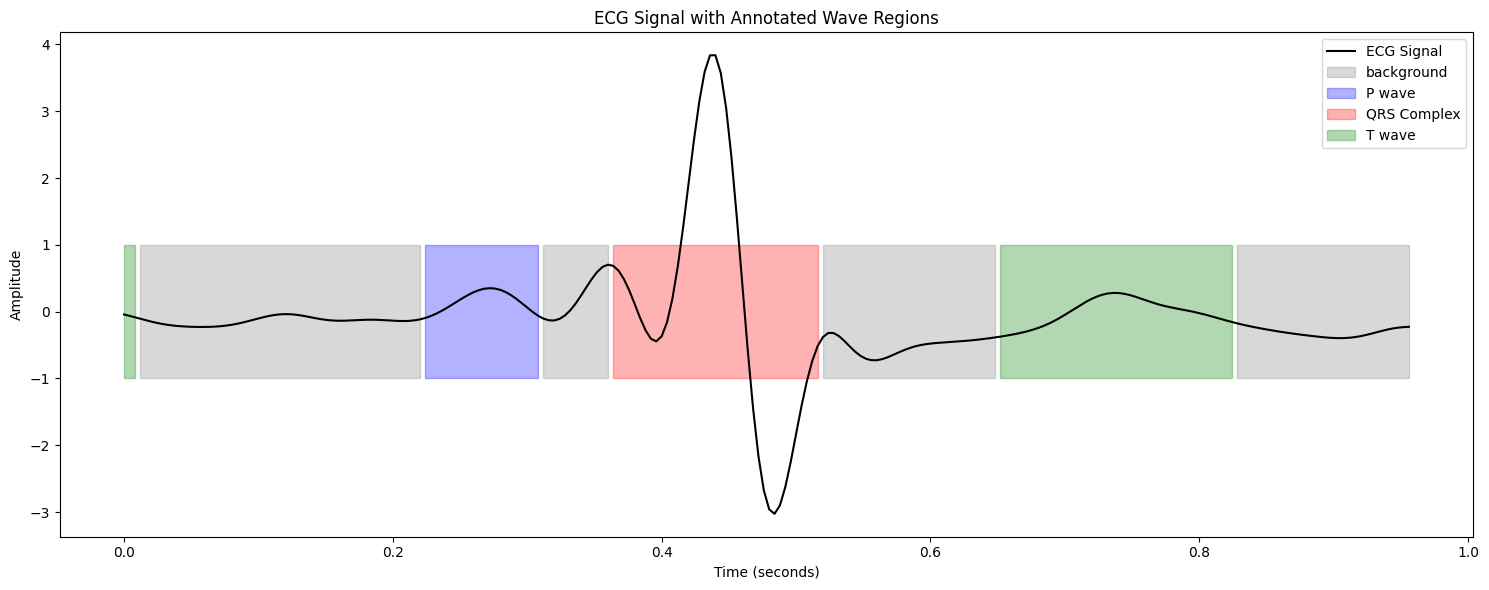

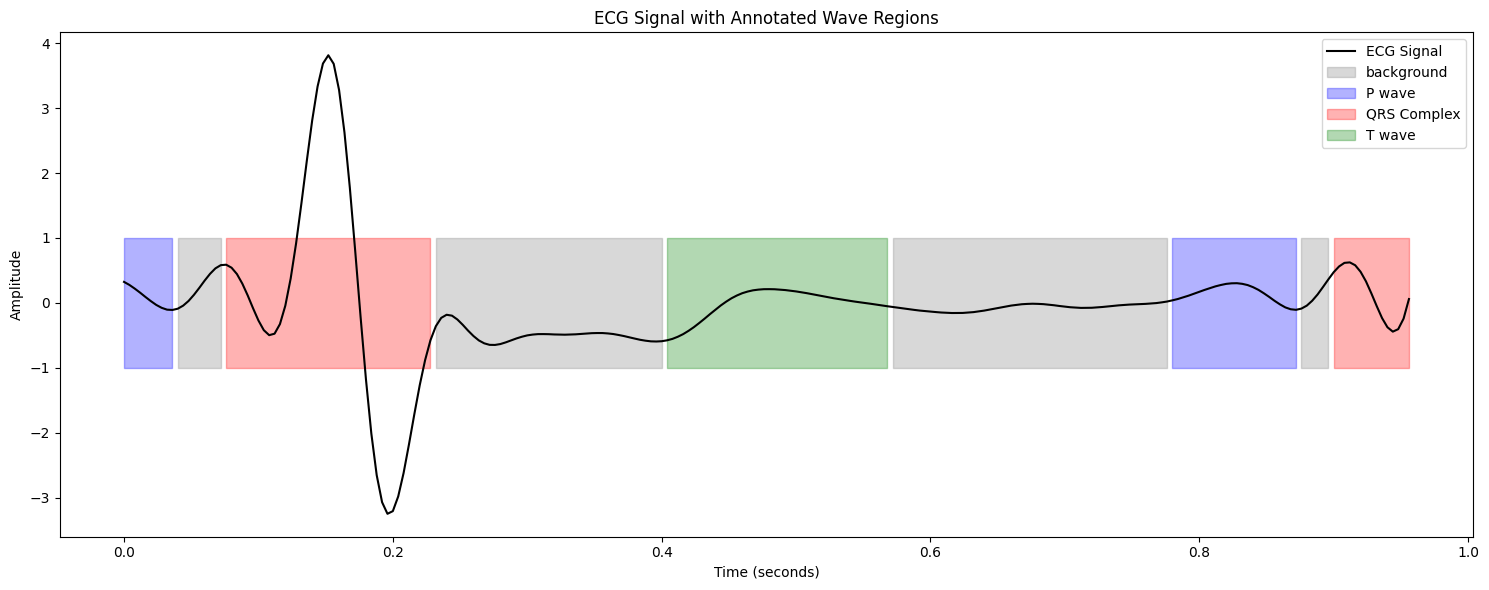

In [12]:


lu_segments_list, lu_masks_list = [], []

for record_path in tqdm(lu_records, desc="Processing LUDB Records"):
    try:

        segments, masks = process_record(
            ludb_path + record_path,
            Type='LUDB',
            extra_ms={'p':0, 'N':20, 't':0},
            target_fs=250
        )
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)

    except Exception as e:
        print(f"Skipping {record_path} due to error: {e}")




display_ecg_with_masks(segments[0].flatten(), masks[0])
display_ecg_with_masks(segments[17].flatten(), masks[17])
display_ecg_with_masks(segments[18].flatten(), masks[18])
display_ecg_with_masks(segments[-1].flatten(), masks[-1])

In [13]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [14]:

X = np.concatenate([qt_segments, lu_segments])

qt_segments = None
lu_segments = None
qt_segments_list = None
lu_segments_list = None

In [15]:

y = np.concatenate([qt_masks, lu_masks])
print(y)

[[0 0 0 ... 0 0 0]
 [2 0 0 ... 2 2 2]
 [3 3 3 ... 0 0 3]
 ...
 [0 0 0 ... 3 3 3]
 [3 3 3 ... 0 0 0]
 [1 1 1 ... 2 2 2]]


In [16]:
import numpy as np

flat_y = y.flatten()

# Count occurrences of each class
unique_classes, class_counts = np.unique(flat_y, return_counts=True)

# Compute total number of labels
total_labels = np.sum(class_counts)
from re import S
import os
# Compute class weights
class_weights = class_counts / total_labels

# Display results
class_weight_dict = dict(zip(unique_classes, class_weights))
print("Class Counts:", dict(zip(unique_classes, class_counts)))
print("Class Weights (Relative Frequency):", class_weight_dict)

# Get weight of class 0
weight_0 = class_weight_dict.get(0, 0)
print(f"Weight of Class 0: {weight_0:.4f}")


Class Counts: {0: 45861096, 1: 9742522, 2: 17298084, 3: 22661258}
Class Weights (Relative Frequency): {0: 0.47990451530593026, 1: 0.10194872574060075, 2: 0.1810124341062688, 3: 0.2371343248472002}
Weight of Class 0: 0.4799


In [17]:
qt_masks = None
lu_masks = None
qt_masks_list = None
lu_masks_list = None

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


In [19]:
from torch.utils.data import Dataset, DataLoader

class ECGWaveformDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.long)

train_dataset = ECGWaveformDataset(X_train, y_train)
val_dataset = ECGWaveformDataset(X_val, y_val)
test_dataset = ECGWaveformDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [20]:
X=None
y=None

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                              padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv1d(F_int, 1, kernel_size=1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNet1D_Enhanced(nn.Module):
    def __init__(self, in_channels=1, n_classes=4, base_filters=64):
        super().__init__()

        # Encoder with residual blocks and multi-scale context
        self.enc1 = ResidualConvBlock1D(in_channels, base_filters)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = ResidualConvBlock1D(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = ResidualConvBlock1D(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool1d(2)

        self.enc4 = ResidualConvBlock1D(base_filters*4, base_filters*8)
        self.pool4 = nn.MaxPool1d(2)

        # Bottleneck with dilated convolution
        self.bottleneck = nn.Sequential(
            ResidualConvBlock1D(base_filters*8, base_filters*16, dilation=2),
            ResidualConvBlock1D(base_filters*16, base_filters*16, dilation=4)
        )

        # Decoder with attention gates
        self.upconv4 = nn.ConvTranspose1d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(base_filters*8, base_filters*8, base_filters//2)
        self.dec4 = ResidualConvBlock1D(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose1d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(base_filters*4, base_filters*4, base_filters//4)
        self.dec3 = ResidualConvBlock1D(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose1d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(base_filters*2, base_filters*2, base_filters//8)
        self.dec2 = ResidualConvBlock1D(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose1d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters//16)
        self.dec1 = ResidualConvBlock1D(base_filters*2, base_filters)

        # Output with multi-scale feature fusion
        self.final_conv = nn.Sequential(
            nn.Conv1d(base_filters, base_filters//2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base_filters//2),
            nn.ReLU(),
            nn.Conv1d(base_filters//2, n_classes, kernel_size=1)
        )

        # Boundary refinement
        self.boundary_refine = nn.Conv1d(n_classes, n_classes, kernel_size=5, padding=2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with attention
        d4 = self.upconv4(b)
        e4 = self.att4(d4, center_crop(e4, d4.shape[-1]))
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, center_crop(e3, d3.shape[-1]))
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, center_crop(e2, d2.shape[-1]))
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, center_crop(e1, d1.shape[-1]))
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        # Output
        out = self.final_conv(d1)

        # Boundary refinement
        out = out + self.boundary_refine(out)  # Residual connection

        return out

def center_crop(enc_feat, target_size):
    _, _, L = enc_feat.size()
    diff = L - target_size
    if diff == 0:
        return enc_feat
    start = diff // 2
    end = start + target_size
    return enc_feat[:, :, start:end]

In [22]:
import torch
import random
import torch.nn.functional as F

class ECGAugment:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x, y):
        
        if len(x.shape) != 3:
            raise ValueError(f"Expected 3D input (B,1,L), got {x.shape}")
        if len(y.shape) != 2:
            raise ValueError(f"Expected 2D mask (B,L), got {y.shape}")

        batch_size, _, seq_len = x.shape

        # Random scaling
        if random.random() < self.p:
            scale = torch.empty(batch_size, 1, 1).uniform_(0.9, 1.1).to(x.device)
            x = x * scale

        # Add Gaussian noise
        if random.random() < self.p:
            x = x + torch.randn_like(x) * 0.01

        # Random time warping
        if random.random() < self.p:
            new_len = random.randint(int(seq_len*0.95), int(seq_len*1.05))

            # Reshape for interpolation (B,1,L) -> (B*1,L) -> (B*1,1,L)
            x_reshaped = x.view(-1, seq_len).unsqueeze(1)
            x_warped = F.interpolate(x_reshaped, size=new_len,
                                   mode='linear', align_corners=True)
            x_warped = F.interpolate(x_warped, size=seq_len,
                                   mode='linear', align_corners=True)
            x = x_warped.view(batch_size, 1, seq_len)

            # Reshape mask (B,L) -> (B,1,L)
            y_reshaped = y.float().unsqueeze(1)
            y_warped = F.interpolate(y_reshaped, size=new_len,
                                   mode='nearest')
            y_warped = F.interpolate(y_warped, size=seq_len,
                                   mode='nearest')
            y = y_warped.squeeze(1).long()

        return x, y

In [23]:
def compute_per_class_loss(output, target, num_classes=4):
    """ Compute loss per class for analysis. """
    per_class_loss = torch.zeros(num_classes, device=device)
    log_probs = F.log_softmax(output, dim=1)  # Convert output to log probabilities

    for cls in range(num_classes):
        mask = (target == cls)  # Mask for class cls
        if mask.sum() > 0:  # Avoid empty class issue
            cls_loss = -log_probs[:, cls, :][mask].mean()  # Compute log loss
            per_class_loss[cls] = cls_loss

    return per_class_loss

def compute_loss_and_metrics(output, target):
    """Compute focal loss and metrics"""
    # Focal loss calculation
    log_probs = F.log_softmax(output, dim=1)
    probs = torch.exp(log_probs)

    # Gather the probabilities of the target classes
    target_probs = probs.gather(1, target.unsqueeze(1)).squeeze(1)
    focal_term = -((1 - target_probs) ** 2.0) * log_probs.gather(1, target.unsqueeze(1)).squeeze(1)

    # Apply class weights
    weights = class_weights.gather(0, target.view(-1)).view_as(focal_term)
    loss = (focal_term * weights).mean()

    # Per-class loss
    per_class_loss = torch.zeros(4, device=device)
    for cls in range(4):
        mask = (target == cls)
        if mask.sum() > 0:
            per_class_loss[cls] = focal_term[mask].mean()

    # Metrics calculation
    preds = torch.argmax(output, dim=1)
    acc = (preds == target).float().mean()

    # Per-class IoU
    ious = torch.zeros(4, device=device)
    for cls in range(4):
        intersection = ((preds == cls) & (target == cls)).sum()
        union = ((preds == cls) | (target == cls)).sum()
        ious[cls] = intersection / (union + 1e-8)

    return loss, per_class_loss, acc.item(), ious


In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Convert inputs to probabilities
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)

        # Gather the probabilities of the target classes
        B, C, L = inputs.shape
        targets = targets.unsqueeze(1)  # (B, 1, L)
        class_probs = probs.gather(1, targets).squeeze(1)  # (B, L)

        # Compute focal loss
        focal = -((1 - class_probs) ** self.gamma) * log_probs.gather(1, targets).squeeze(1)

        # Apply class weights if provided
        if self.alpha is not None:
            alpha_weight = self.alpha.gather(0, targets.view(-1)).view_as(focal)
            focal = focal * alpha_weight

        # Reduce loss
        if self.reduction == 'mean':
            return focal.mean()
        elif self.reduction == 'sum':
            return focal.sum()
        else:
            return focal

In [25]:
import torch.nn as nn
import torch.optim as optim



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNet1D_Enhanced(n_classes=4).to(device)

augmenter = ECGAugment(p=0.5)  

class_weights = torch.tensor([0.3, 0.3, 0.25, 0.15], device=device)
best_weights = class_weights.clone()
best_val_loss = float('inf')

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


In [26]:
def update_weights(val_class_loss, momentum=0.8, min_weight=0.1):
    """Update class weights with stability controls"""
    global class_weights, best_weights, best_val_loss

    # Calculate new weights
    new_weights = val_class_loss / val_class_loss.sum()
    new_weights = torch.clamp(new_weights, min_weight, 1.0)  # Constrain weights
    new_weights = new_weights / new_weights.sum()  # Renormalize

    # Apply momentum
    class_weights = momentum * class_weights + (1 - momentum) * new_weights

    # Save best weights
    current_val_loss = val_class_loss.mean()
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_weights = class_weights.clone()


In [27]:
def train_epoch(train_loader):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_ious = torch.zeros(4, device=device)

    for X_batch, y_batch in tqdm(train_loader, desc="Training"):
        # Ensure proper dimensions
        if len(X_batch.shape) == 2:  # (B,L) -> (B,1,L)
            X_batch = X_batch.unsqueeze(1)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Apply augmentations
        X_batch, y_batch = augmenter(X_batch, y_batch)

        optimizer.zero_grad()
        output = model(X_batch)  # (B,4,L)

        # Compute loss and metrics
        loss, class_loss, acc, ious = compute_loss_and_metrics(output, y_batch)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_ious += ious

    return epoch_loss/len(train_loader), epoch_acc/len(train_loader), epoch_ious/len(train_loader)

def evaluate(val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    val_ious = torch.zeros(4, device=device)
    val_class_loss = torch.zeros(4, device=device)

    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc="Validating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)

            loss, class_loss, acc, ious = compute_loss_and_metrics(output, y_batch)

            val_loss += loss.item()
            val_acc += acc
            val_ious += ious
            val_class_loss += class_loss * len(X_batch)

    avg_class_loss = val_class_loss / len(val_loader.dataset)
    return (val_loss/len(val_loader), val_acc/len(val_loader),
            val_ious/len(val_loader), avg_class_loss)

In [28]:
def train(train_loader, val_loader, epochs=50):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_ious = []
    val_ious = []
    val_class_losses = []
    class_weights_history = []


    for epoch in range(epochs):
        train_loss, train_acc, train_iou = train_epoch(train_loader)
        val_loss, val_acc, val_iou, val_class_loss = evaluate(val_loader)

        scheduler.step(val_loss)
        update_weights(val_class_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_ious.append(train_iou.cpu().numpy())
        val_ious.append(val_iou.cpu().numpy())
        val_class_losses.append(val_class_loss.cpu().numpy())
        class_weights_history.append(class_weights.cpu().numpy())


        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | IoU: {train_iou.cpu().numpy()}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | IoU: {val_iou.cpu().numpy()}")
        print(f"Class Losses: {val_class_loss.cpu().numpy()}")
        print(f"Class Weights: {class_weights.cpu().numpy()}")

    return train_losses, val_losses, train_accs, val_accs, train_ious, val_ious, val_class_losses, class_weights_history

In [29]:
train_history = train(train_loader, val_loader, epochs=20)

Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.37it/s]



Epoch 1/20:
Train Loss: 0.0181 | Acc: 0.9063 | IoU: [0.83380884 0.7728503  0.8941493  0.7965033 ]
Val Loss: 0.0158 | Acc: 0.9191 | IoU: [0.8509581 0.79718   0.9009429 0.835031 ]
Class Losses: [0.04710918 0.10582986 0.06070072 0.08370318]
Class Weights: [0.2716868  0.31118372 0.24082877 0.17630078]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.48it/s]



Epoch 2/20:
Train Loss: 0.0146 | Acc: 0.9225 | IoU: [0.85795814 0.8020357  0.9104925  0.8369267 ]
Val Loss: 0.0137 | Acc: 0.9282 | IoU: [0.86606413 0.8123371  0.91370845 0.85479623]
Class Losses: [0.04712581 0.08419684 0.04308362 0.07065859]
Class Weights: [0.2558093  0.3176609  0.227824   0.19870584]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.31it/s]



Epoch 3/20:
Train Loss: 0.0141 | Acc: 0.9256 | IoU: [0.8627109  0.80690116 0.91304696 0.8465901 ]
Val Loss: 0.0140 | Acc: 0.9237 | IoU: [0.8596197 0.7997981 0.9118515 0.8424989]
Class Losses: [0.04309618 0.0867492  0.05492128 0.07677616]
Class Weights: [0.2376028  0.32046524 0.22425713 0.2176749 ]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.69it/s]



Epoch 4/20:
Train Loss: 0.0137 | Acc: 0.9268 | IoU: [0.8640656  0.80844504 0.9144791  0.8510196 ]
Val Loss: 0.0130 | Acc: 0.9307 | IoU: [0.8693523 0.8143753 0.9214545 0.8618073]
Class Losses: [0.052319   0.0632963  0.05046318 0.05573447]
Class Weights: [0.23725621 0.31344396 0.22490637 0.22439349]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.11it/s]



Epoch 5/20:
Train Loss: 0.0136 | Acc: 0.9274 | IoU: [0.8650067  0.8092548  0.91509515 0.8524164 ]
Val Loss: 0.0133 | Acc: 0.9290 | IoU: [0.8671255  0.82213676 0.91790825 0.8517512 ]
Class Losses: [0.04913776 0.07753588 0.05072884 0.05873533]
Class Weights: [0.23142284 0.3164252  0.22289056 0.22926144]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.41it/s]



Epoch 6/20:
Train Loss: 0.0134 | Acc: 0.9277 | IoU: [0.8651682  0.80965257 0.9155099  0.8533194 ]
Val Loss: 0.0129 | Acc: 0.9305 | IoU: [0.87003773 0.8189633  0.9226407  0.85472625]
Class Losses: [0.04779316 0.06930841 0.04225644 0.06597014]
Class Weights: [0.22755921 0.31465793 0.21581903 0.24196388]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.55it/s]



Epoch 7/20:
Train Loss: 0.0134 | Acc: 0.9280 | IoU: [0.8655194 0.8100332 0.9157675 0.8546408]
Val Loss: 0.0128 | Acc: 0.9310 | IoU: [0.8690385 0.8238437 0.9234973 0.8575251]
Class Losses: [0.05815706 0.06534123 0.0420684  0.04663336]
Class Weights: [0.2368608  0.31331092 0.21230498 0.23752338]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 77.01it/s]



Epoch 8/20:
Train Loss: 0.0134 | Acc: 0.9284 | IoU: [0.86636716 0.811036   0.91595095 0.85516727]
Val Loss: 0.0131 | Acc: 0.9310 | IoU: [0.87121886 0.8153604  0.92356044 0.85674286]
Class Losses: [0.04549846 0.08635367 0.05092214 0.0557048 ]
Class Weights: [0.22764583 0.32306907 0.21254975 0.23673542]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.88it/s]



Epoch 9/20:
Train Loss: 0.0133 | Acc: 0.9283 | IoU: [0.86610436 0.81098306 0.91600883 0.8554689 ]
Val Loss: 0.0135 | Acc: 0.9248 | IoU: [0.8612016  0.79894185 0.9103307  0.84950686]
Class Losses: [0.04493842 0.07657257 0.06024266 0.06684003]
Class Weights: [0.2182708  0.32005984 0.21850657 0.24316286]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.32it/s]



Epoch 10/20:
Train Loss: 0.0131 | Acc: 0.9284 | IoU: [0.8659157  0.8107201  0.91617894 0.8562749 ]
Val Loss: 0.0132 | Acc: 0.9290 | IoU: [0.86880267 0.8216503  0.90896744 0.85486513]
Class Losses: [0.04605758 0.07373891 0.0591272  0.06185149]
Class Weights: [0.21287438 0.31729913 0.2239193  0.24590726]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.96it/s]



Epoch 11/20:
Train Loss: 0.0130 | Acc: 0.9282 | IoU: [0.8655657  0.81060094 0.9162028  0.8559442 ]
Val Loss: 0.0135 | Acc: 0.9233 | IoU: [0.8560065  0.7940257  0.9174666  0.84458673]
Class Losses: [0.05710616 0.08268451 0.03774815 0.05826154]
Class Weights: [0.21873555 0.32397026 0.2111525  0.2461418 ]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 77.11it/s]



Epoch 12/20:
Train Loss: 0.0115 | Acc: 0.9351 | IoU: [0.8774203  0.82433486 0.92406166 0.8705664 ]
Val Loss: 0.0109 | Acc: 0.9379 | IoU: [0.88190496 0.8308034  0.92892975 0.8754463 ]
Class Losses: [0.04570128 0.06135269 0.04077476 0.04292198]
Class Weights: [0.22290573 0.32350385 0.21167387 0.24191667]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 77.24it/s]



Epoch 13/20:
Train Loss: 0.0111 | Acc: 0.9365 | IoU: [0.88000727 0.8269638  0.9252714  0.87363493]
Val Loss: 0.0108 | Acc: 0.9384 | IoU: [0.88310695 0.8331503  0.9280023  0.87645704]
Class Losses: [0.04417039 0.05905525 0.04132777 0.04421816]
Class Weights: [0.2251223  0.32137105 0.21312511 0.24038167]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.95it/s]



Epoch 14/20:
Train Loss: 0.0110 | Acc: 0.9371 | IoU: [0.88096404 0.82840514 0.9258629  0.87448955]
Val Loss: 0.0107 | Acc: 0.9393 | IoU: [0.88465923 0.83632517 0.9286095  0.87789893]
Class Losses: [0.04272755 0.0588824  0.03769678 0.04694252]
Class Weights: [0.22597997 0.32032654 0.21098001 0.24271363]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.93it/s]



Epoch 15/20:
Train Loss: 0.0109 | Acc: 0.9375 | IoU: [0.8817189  0.82903826 0.92618275 0.87561476]
Val Loss: 0.0108 | Acc: 0.9385 | IoU: [0.8837085  0.8307145  0.9271904  0.87752473]
Class Losses: [0.04166446 0.0615932  0.03893577 0.04876768]
Class Weights: [0.22442058 0.32076985 0.20956275 0.24524695]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.75it/s]



Epoch 16/20:
Train Loss: 0.0108 | Acc: 0.9377 | IoU: [0.8820467  0.8293415  0.92645013 0.87634796]
Val Loss: 0.0107 | Acc: 0.9390 | IoU: [0.8844217  0.8321271  0.93068236 0.8770411 ]
Class Losses: [0.04226156 0.06020427 0.03847165 0.04662471]
Class Weights: [0.22460052 0.32081246 0.20867303 0.24591409]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.53it/s]



Epoch 17/20:
Train Loss: 0.0108 | Acc: 0.9379 | IoU: [0.8823948 0.829831  0.9266728 0.8765867]
Val Loss: 0.0106 | Acc: 0.9407 | IoU: [0.8875713  0.8401921  0.9294298  0.87990576]
Class Losses: [0.04089431 0.06256316 0.03813527 0.04528039]
Class Weights: [0.22344735 0.32360786 0.2077525  0.24519238]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.26it/s]



Epoch 18/20:
Train Loss: 0.0107 | Acc: 0.9382 | IoU: [0.8828982  0.8303564  0.92684394 0.87738246]
Val Loss: 0.0109 | Acc: 0.9380 | IoU: [0.8829266  0.83014107 0.9273259  0.8754803 ]
Class Losses: [0.04067199 0.06105798 0.04067424 0.0506089 ]
Class Weights: [0.22090216 0.32215452 0.2083486  0.2485948 ]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.57it/s]



Epoch 19/20:
Train Loss: 0.0106 | Acc: 0.9383 | IoU: [0.88291126 0.8303723  0.92707944 0.877665  ]
Val Loss: 0.0106 | Acc: 0.9393 | IoU: [0.88463205 0.8346392  0.92933404 0.87852114]
Class Losses: [0.04402396 0.05817932 0.03765651 0.04359927]
Class Weights: [0.22471496 0.32114848 0.20773056 0.2464061 ]


Validating: 100%|██████████| 1867/1867 [00:24<00:00, 76.78it/s]


Epoch 20/20:
Train Loss: 0.0106 | Acc: 0.9385 | IoU: [0.8834467  0.83097726 0.9271687  0.87814045]
Val Loss: 0.0106 | Acc: 0.9396 | IoU: [0.8851729 0.8335493 0.930245  0.8791388]
Class Losses: [0.04279378 0.05548522 0.03890512 0.04561813]
Class Weights: [0.22659174 0.31762397 0.20874971 0.2470347 ]


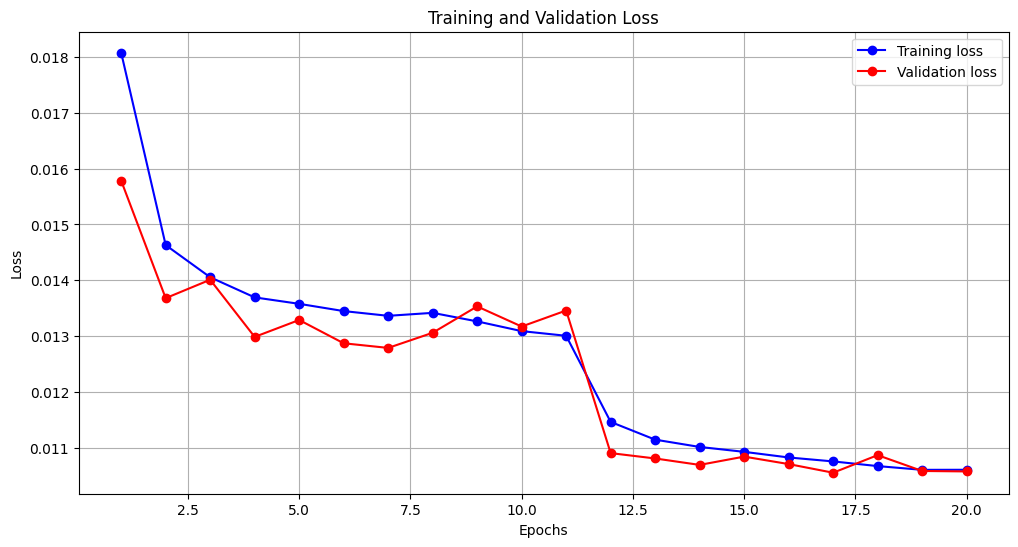

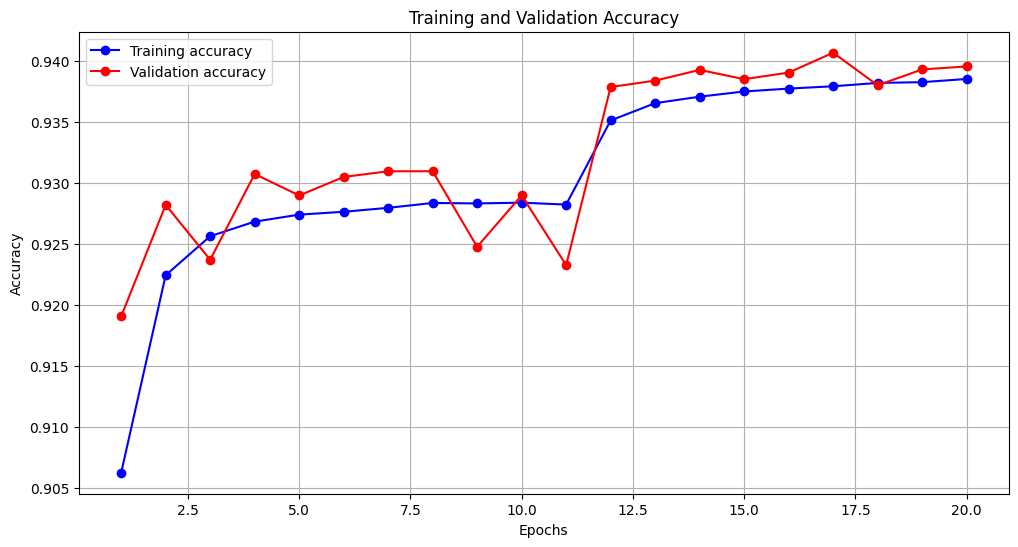

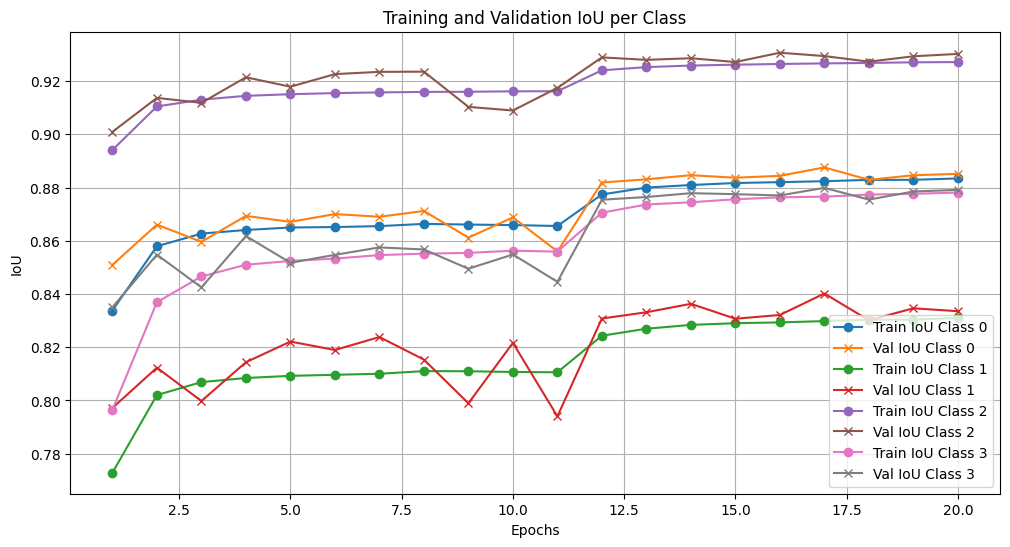

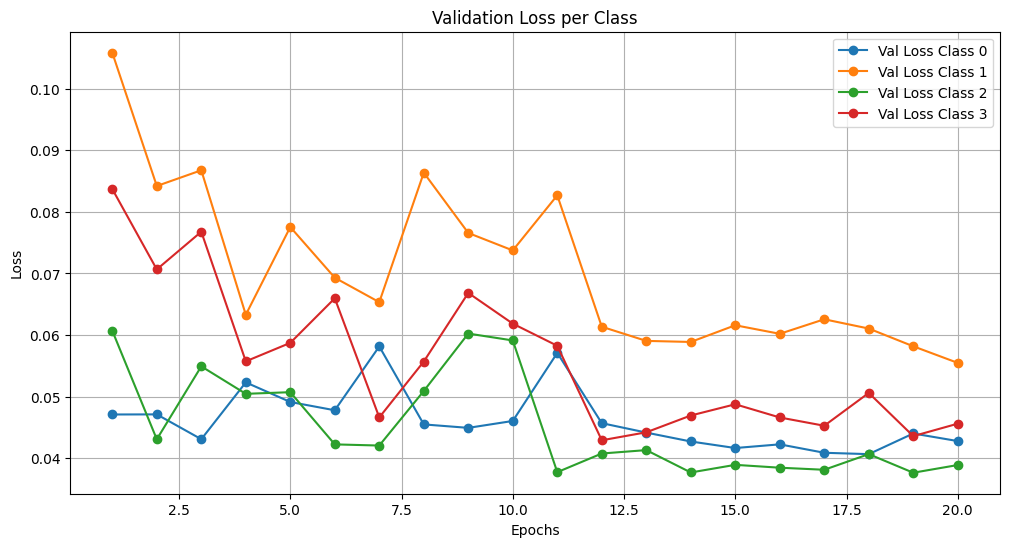

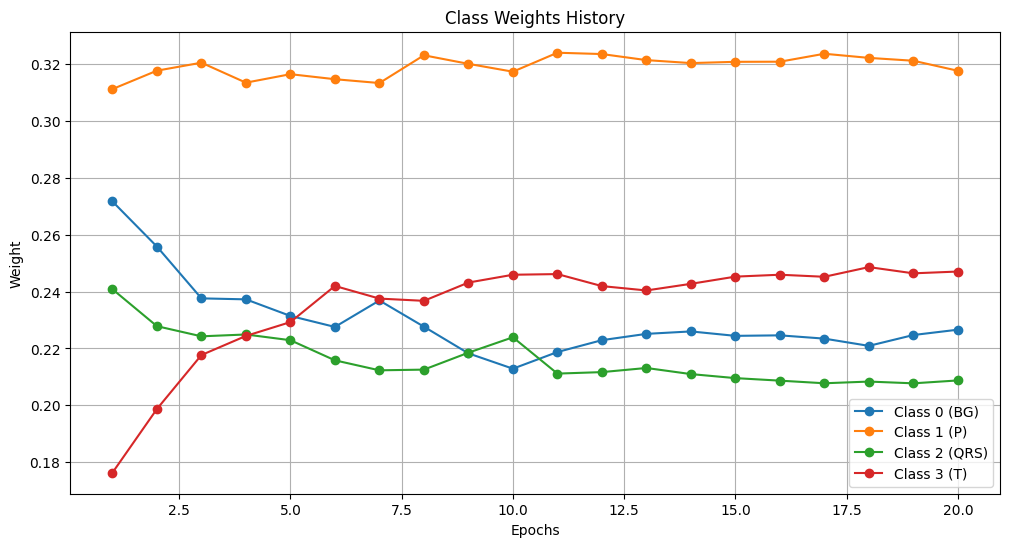

In [30]:
train_losses, val_losses, train_accs, val_accs, train_ious, val_ious, val_class_losses, class_weights_history = train_history

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accs, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accs, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot per-class IoU
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(epochs, [iou[i] for iou in train_ious], 'o-', label=f'Train IoU Class {i}')
    plt.plot(epochs, [iou[i] for iou in val_ious], 'x-', label=f'Val IoU Class {i}')
plt.title('Training and Validation IoU per Class')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()

# Plot per-class loss
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(epochs, [loss[i] for loss in val_class_losses], 'o-', label=f'Val Loss Class {i}')
plt.title('Validation Loss per Class')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot class weights history
plt.figure(figsize=(12, 6))
class_labels = ['BG', 'P', 'QRS', 'T']
for i in range(4):
    plt.plot(epochs, [weights[i] for weights in class_weights_history], 'o-', label=f'Class {i} ({class_labels[i]})')
plt.title('Class Weights History')
plt.xlabel('Epochs')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def test(model, test_loader):
    model.eval()

    test_acc = 0.0

    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader):
            X_batch = X_batch.to(device)  # shape: (1, 1, L)

            # Handle label shape
            if y_batch.dim() == 3 and y_batch.shape[-1] > 1:
                y_batch = y_batch.argmax(dim=2)
            y_batch = y_batch.to(device)  # shape: (1, L)

            output = model(X_batch)       # shape: (1, C, L)
            preds = torch.argmax(output, dim=1)  # shape: (1, L)

            acc = (preds == y_batch).float().mean()
            test_acc += acc.item()

            # === Visualization ===
            if i == 0:  # plot first sample
                signal = X_batch[0, 0].cpu().numpy()
                pred_mask = preds[0].cpu().numpy()
                true_mask = y_batch[0].cpu().numpy()
                time = np.arange(len(signal))

                plt.figure(figsize=(15, 6))
                plt.plot(time, signal, color='black', label='ECG Signal')

                # Plot predictions
                for class_idx, color, label in zip([1, 2, 3], ['blue', 'red', 'green'], ['P', 'QRS', 'T']):
                    plt.fill_between(time, -1, 1, where=pred_mask == class_idx, color=color, alpha=0.3, label=f'Predicted {label}')
                    plt.fill_between(time, -1, 1, where=true_mask == class_idx, color=color, alpha=0.1, label=f'True {label}', linestyle='dashed')

                plt.title('Predicted vs Ground Truth Mask on Test Sample')
                plt.xlabel('Time (samples)')
                plt.ylabel('Amplitude')
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.show()

    avg_acc = test_acc / len(test_loader)
    print(f"✅ Test Accuracy: {avg_acc * 100:.2f}%")

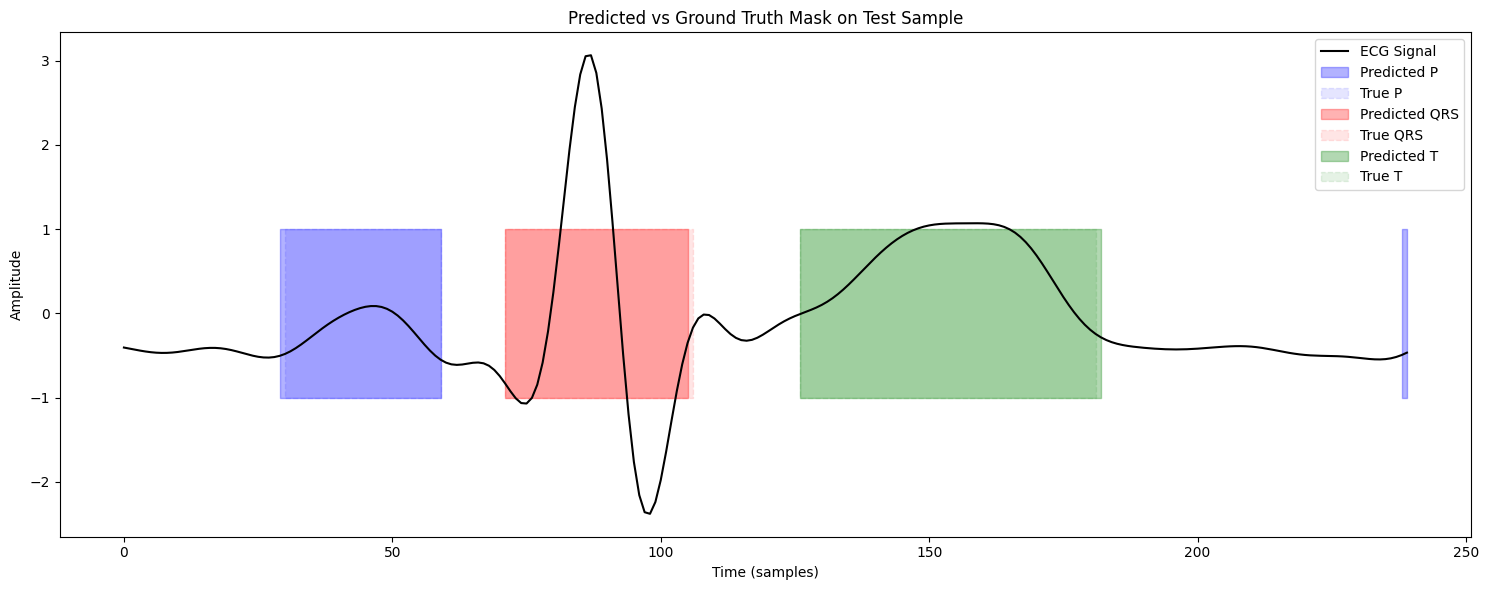

✅ Test Accuracy: 93.96%


In [32]:
test(model, test_loader)


In [33]:
from torchinfo import summary

summary(model, input_size=(1, 1, 240)) 

Layer (type:depth-idx)                   Output Shape              Param #
UNet1D_Enhanced                          [1, 4, 240]               --
├─ResidualConvBlock1D: 1-1               [1, 64, 240]              --
│    └─Sequential: 2-1                   [1, 64, 240]              --
│    │    └─Conv1d: 3-1                  [1, 64, 240]              128
│    │    └─BatchNorm1d: 3-2             [1, 64, 240]              128
│    └─Conv1d: 2-2                       [1, 64, 240]              256
│    └─BatchNorm1d: 2-3                  [1, 64, 240]              128
│    └─Conv1d: 2-4                       [1, 64, 240]              12,352
│    └─BatchNorm1d: 2-5                  [1, 64, 240]              128
├─MaxPool1d: 1-2                         [1, 64, 120]              --
├─ResidualConvBlock1D: 1-3               [1, 128, 120]             --
│    └─Sequential: 2-6                   [1, 128, 120]             --
│    │    └─Conv1d: 3-3                  [1, 128, 120]             8,320
│  

In [34]:
!pip install torchviz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00


In [35]:
torch.save(model, "full_unet1d_ecg_qrs_model.pth")


In [36]:
torch.save(model.state_dict(), "updated_unet1d_ecg_qrs.pth")


# testing model on ecg signal

In [37]:
model = UNet1D_Enhanced(n_classes=4)
model.load_state_dict(torch.load("/kaggle/working/updated_unet1d_ecg_qrs.pth", map_location=device))
model.to(device)
model.eval()


UNet1D_Enhanced(
  (enc1): ResidualConvBlock1D(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ResidualConvBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [38]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    model.eval()
    signal = signal[:len(signal) - (len(signal) % window_size)]  # crop to multiple of window_size
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    target_fs = 250
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)

    segments = []
    predictions = []

    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)

    with torch.no_grad():
        for window in segments:
            window = torch.tensor(window, dtype=torch.float32).to(device)
            output = model(window)  # (1, C, L)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (L,)
            predictions.append(pred)

    full_prediction = np.concatenate(predictions)
    return full_prediction, segments, predictions

In [39]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries


In [40]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # in seconds

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            plt.fill_between(
                time[start:end],
                -1, 1,
                color=wave_colors.get(wave_type, 'gray'),
                alpha=0.3,
                label=f'Predicted {wave_type}'
            )

    # Prevent duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.title("ECG Signal with Predicted Wave Regions", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Optional zoom
    if zoom[1] is None:
        plt.xlim(zoom[0], time[-1])
    else:
        plt.xlim(zoom)

    plt.show()


6000
{'P': [(955, 955), (959, 971), (1178, 1184), (2382, 2395), (2600, 2605), (3792, 3825), (4014, 4037), (5220, 5236), (5432, 5449), (5620, 5639), (5850, 5862), (5868, 5868), (5968, 5968)], 'QRS': [(0, 55), (197, 262), (403, 468), (602, 665), (802, 864), (995, 1030), (1192, 1244), (1410, 1474), (1617, 1677), (1817, 1885), (2018, 2085), (2222, 2286), (2417, 2451), (2615, 2659), (2826, 2890), (3037, 3102), (3242, 3307), (3446, 3508), (3645, 3709), (3840, 3872), (4040, 4087), (4241, 4308), (4457, 4521), (4661, 4727), (4866, 4934), (5065, 5132), (5265, 5296), (5464, 5512), (5655, 5722), (5869, 5937)], 'T': [(57, 135), (263, 344), (469, 479), (488, 549), (671, 742), (866, 943), (1037, 1131), (1245, 1343), (1475, 1553), (1681, 1766), (1894, 1970), (2086, 2159), (2287, 2376), (2462, 2547), (2660, 2758), (2892, 2970), (3103, 3180), (3308, 3387), (3538, 3586), (3710, 3783), (3786, 3791), (3876, 3973), (4095, 4189), (4311, 4395), (4523, 4603), (4730, 4804), (4958, 5000), (5139, 5206), (5303, 53

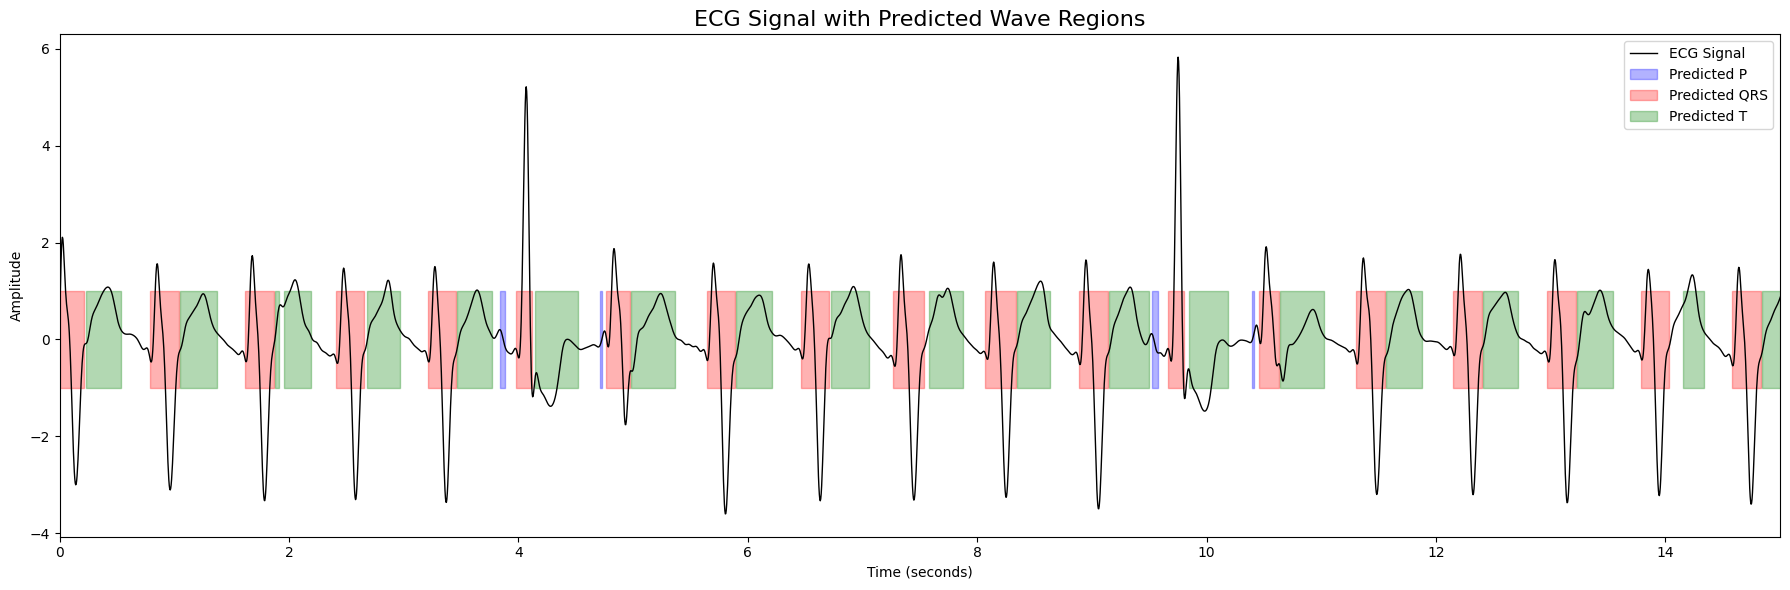

In [41]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/104')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

6000
{'P': [(138, 165), (332, 359), (525, 551), (715, 738), (894, 922), (1084, 1109), (1272, 1294), (1459, 1485), (1643, 1670), (1831, 1857), (2019, 2045), (2206, 2232), (2395, 2420), (2581, 2607), (2767, 2794), (2963, 2987), (3150, 3175), (3336, 3364), (3533, 3555), (3720, 3745), (3904, 3933), (4094, 4120), (4287, 4313), (4481, 4507), (4667, 4694), (4859, 4889), (5055, 5082), (5247, 5272), (5434, 5463), (5626, 5653), (5815, 5844)], 'QRS': [(0, 20), (172, 203), (367, 394), (557, 587), (745, 773), (928, 957), (1115, 1145), (1303, 1332), (1490, 1520), (1677, 1706), (1863, 1894), (2051, 2081), (2239, 2267), (2428, 2457), (2613, 2641), (2801, 2828), (2993, 3022), (3181, 3210), (3370, 3400), (3563, 3591), (3751, 3780), (3939, 3969), (4126, 4155), (4320, 4348), (4513, 4542), (4701, 4730), (4896, 4926), (5088, 5117), (5278, 5306), (5469, 5499), (5660, 5689), (5850, 5880)], 'T': [(43, 80), (222, 264), (420, 461), (612, 652), (793, 836), (979, 1020), (1167, 1209), (1353, 1396), (1538, 1582), (1

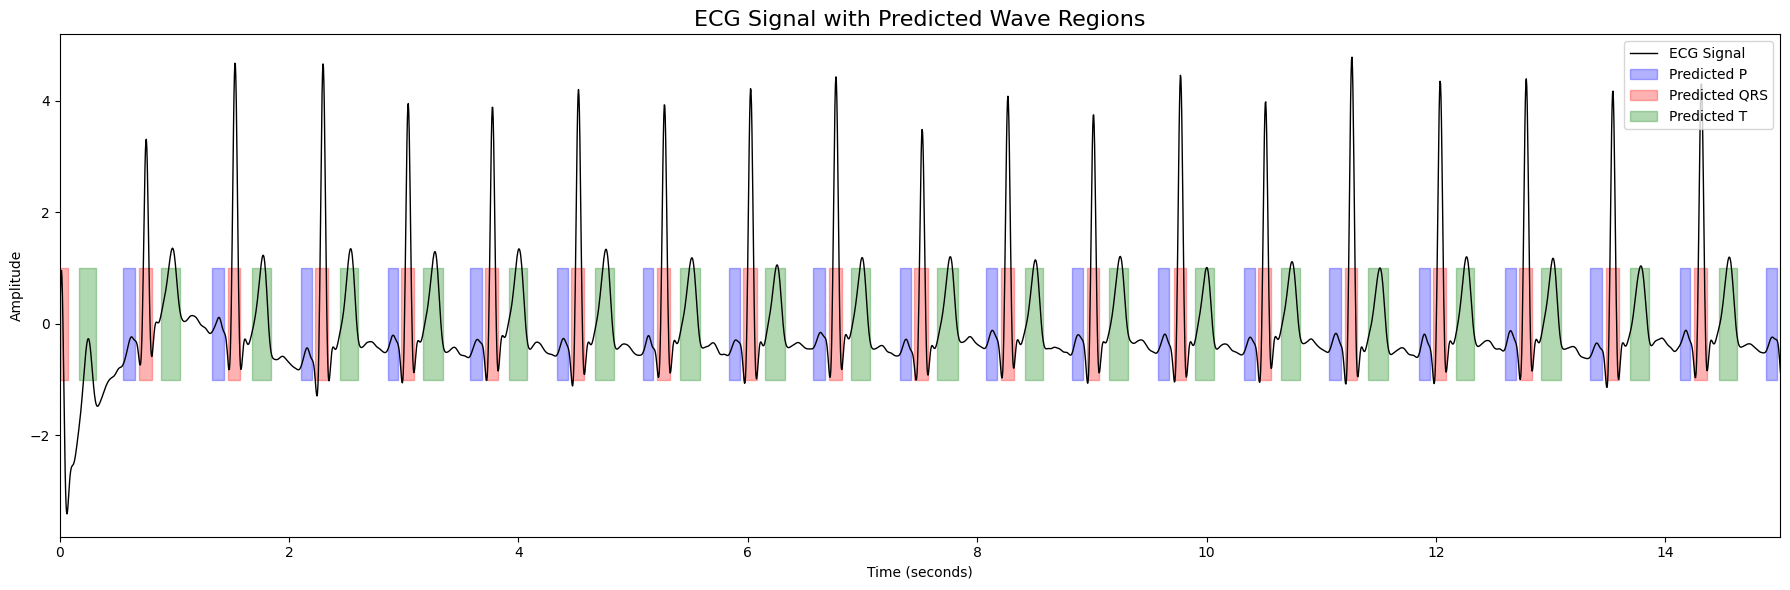

In [42]:


#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/116')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

6000
{'P': [(106, 130), (270, 295), (440, 461), (602, 626), (768, 795), (940, 966), (1105, 1131), (1270, 1292), (1435, 1459), (1608, 1631), (1775, 1801), (1945, 1966), (2108, 2132), (2275, 2300), (2440, 2465), (2612, 2633), (2783, 2807), (2948, 2973), (3114, 3137), (3282, 3306), (3457, 3484), (3626, 3651), (3795, 3819), (3961, 3986), (4132, 4154), (4297, 4318), (4320, 4320), (4466, 4492), (4636, 4659), (4803, 4826), (4965, 4989), (5134, 5158), (5302, 5324), (5466, 5490), (5626, 5651), (5793, 5816), (5958, 5980)], 'QRS': [(136, 162), (302, 327), (467, 493), (633, 659), (804, 827), (971, 996), (1138, 1163), (1300, 1324), (1468, 1493), (1640, 1665), (1809, 1833), (1973, 1999), (2138, 2164), (2307, 2332), (2475, 2499), (2644, 2669), (2812, 2839), (2981, 3005), (3145, 3170), (3314, 3340), (3490, 3516), (3659, 3685), (3826, 3852), (3992, 4019), (4162, 4186), (4330, 4354), (4502, 4526), (4668, 4692), (4832, 4858), (4997, 5023), (5164, 5191), (5330, 5356), (5498, 5523), (5659, 5684), (5825, 58

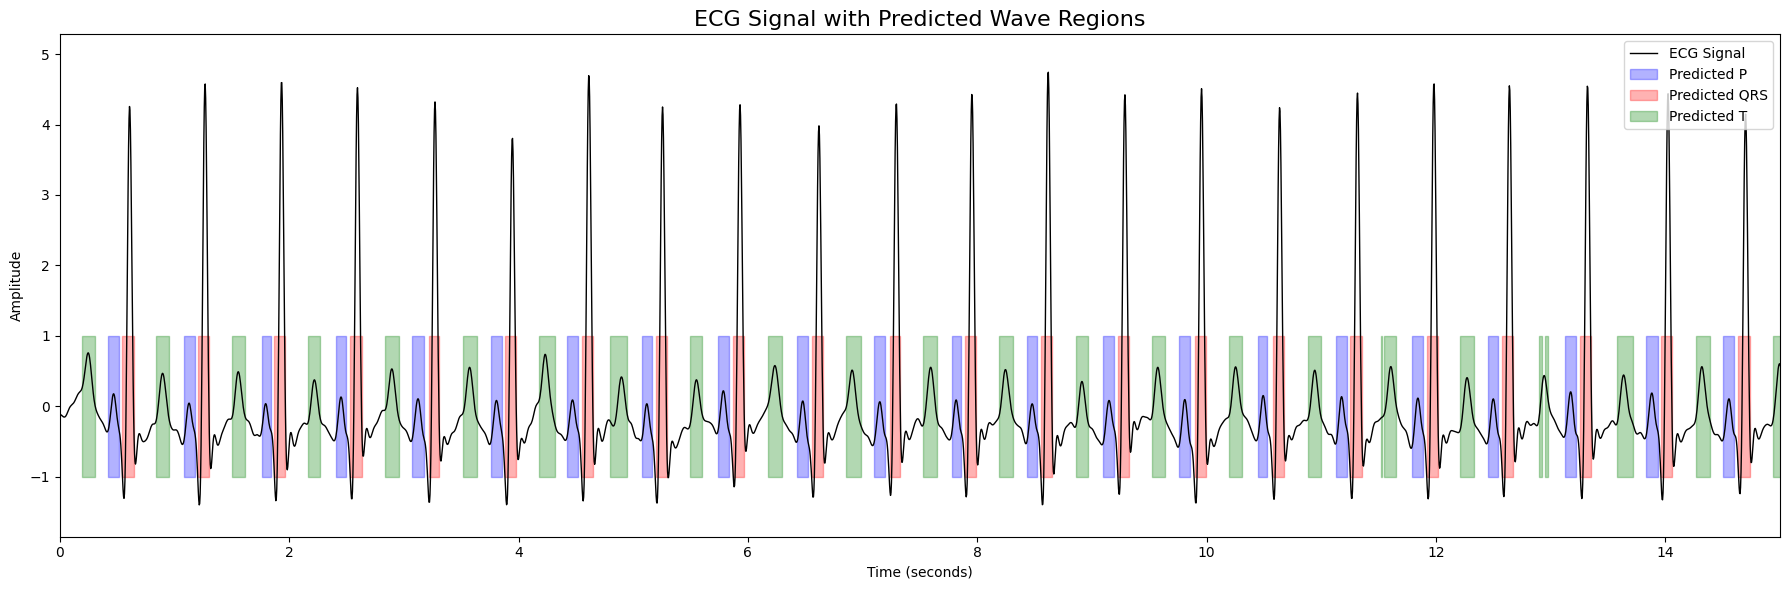

In [43]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/205')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))

6000
{'P': [(79, 104), (279, 298), (470, 493), (664, 686), (851, 873), (1039, 1058), (1228, 1252), (1419, 1441), (1602, 1621), (1781, 1803), (1965, 1985), (2148, 2170), (2331, 2357), (2520, 2540), (2697, 2722), (2876, 2905), (3078, 3098), (3262, 3284), (3439, 3461), (3625, 3646), (3807, 3832), (3999, 4020), (4185, 4207), (4368, 4391), (4554, 4576), (4748, 4770), (4932, 4954), (5110, 5132), (5290, 5316), (5474, 5501), (5668, 5691), (5818, 5833)], 'QRS': [(113, 150), (305, 339), (499, 535), (692, 723), (881, 915), (1065, 1102), (1259, 1294), (1449, 1483), (1628, 1661), (1811, 1846), (1992, 2028), (2177, 2213), (2365, 2397), (2400, 2402), (2549, 2584), (2728, 2764), (2915, 2951), (3106, 3140), (3291, 3327), (3469, 3505), (3654, 3688), (3840, 3875), (4028, 4064), (4213, 4248), (4398, 4432), (4584, 4622), (4778, 4809), (4962, 4995), (5140, 5174), (5322, 5360), (5511, 5547), (5697, 5733), (5834, 5900)], 'T': [(0, 44), (162, 239), (367, 441), (550, 630), (745, 820), (930, 1003), (1115, 1191),

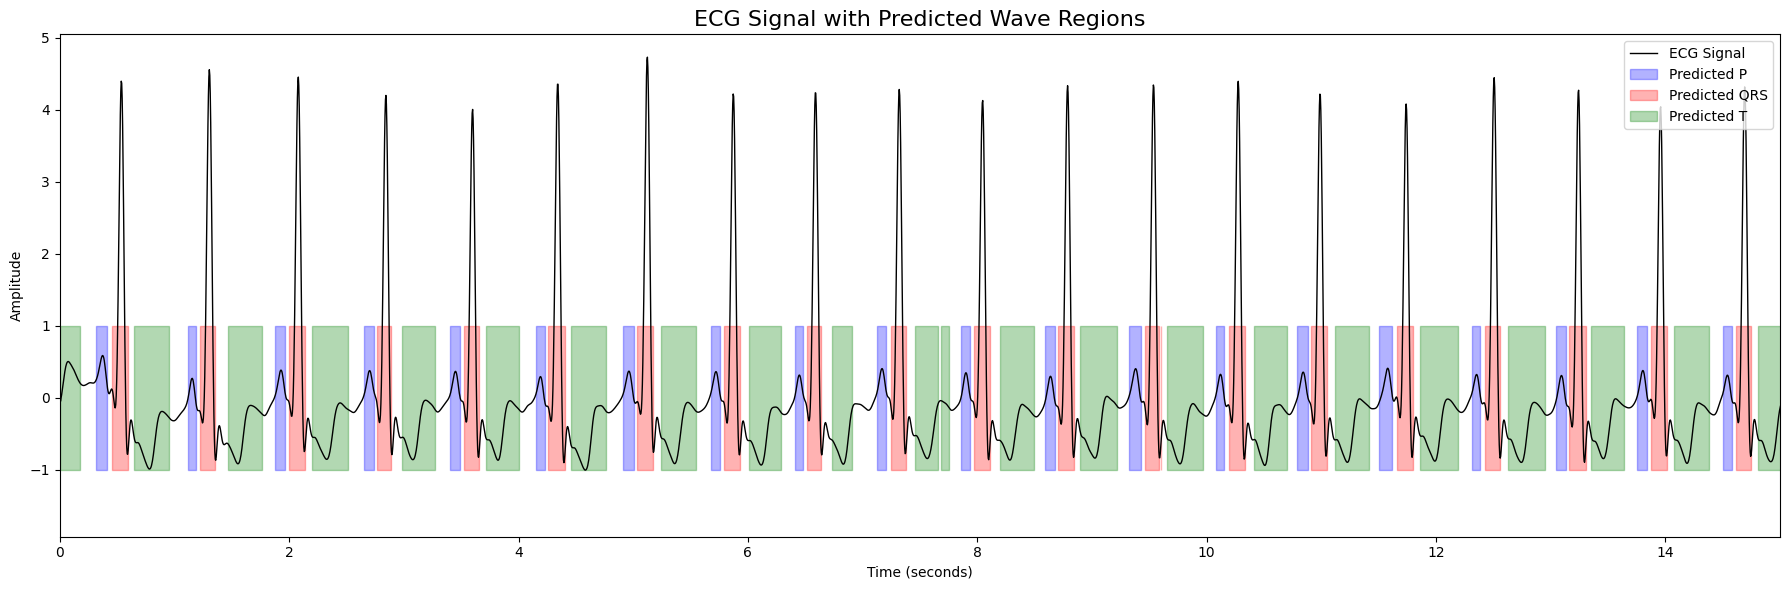

In [44]:

#record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/ecgiddb/1.0.0/Person_48/rec_1')

record = wfdb.rdrecord(path+'/physionet.org/files/mitdb/1.0.0/223')
signal = record.p_signal[:, 0]  # lead I
fs = record.fs
signal=signal[(10):(25*fs)]

# Predict
pred_labels, segments, _ = predict_full_ecg(signal, model, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
print(len(signal))
# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)
visualize_boundaries(signal, boundaries, fs=250, zoom=(0, 15))